In [5]:
import sys
sys.path.append('D:\\SMP_stability')
from pre_processor import PreProcessor
from instability_modelling import R2015_point_instability
from logging_class import LoggerConfig, error_handling_decorator

# Configuration
log_to_file = True  # Set to False if you don't want file logging
LoggerConfig.setup_logging(log_to_file)

pnt_file = '.pnt_data\\190110_BUN\\SMP\\FILE0245.pnt'
profile = PreProcessor.run(pnt_file)
model = R2015_point_instability.run(profile)

2025-02-27 17:14:22,113 - INFO - File logging enabled: pipeline.log
2025-02-27 17:14:22,115 - INFO - starting PreProcessor...
2025-02-27 17:14:22,873 - INFO -    Performing layer clustering for FILE0245.pnt
2025-02-27 17:14:23,218 - INFO -    Optimal number of clusters: 4, using 4 clusters with adjustment.
2025-02-27 17:14:23,230 - INFO -    Layer clustering completed successfully.
2025-02-27 17:14:23,230 - INFO -    get layer properties for FILE0245.pnt
2025-02-27 17:14:26,857 - INFO - starting R2015_point_instability...
2025-02-27 17:14:26,859 - INFO -    compute_skier_stability_S for FILE0245.pnt 20 layers
2025-02-27 17:14:27,216 - INFO -    compute_critical_cut_length_rc for FILE0245.pnt 20 layers


In [29]:
weac.plot.deformed?

Signature:
weac.plot.deformed(
    instance,
    xsl,
    xwl,
    z,
    phi,
    dz=2,
    scale=100,
    window=inf,
    pad=2,
    levels=300,
    aspect=2,
    field='principal',
    normalize=True,
    dark=False,
    filename='cont',
)
Docstring:
Plot 2D deformed solution with displacement or stress fields.

Arguments
---------
instance : object
    Instance of layered class.
xsl : ndarray
    Discretized slab x-coordinates (mm).
xwl : ndarray
    Discretized weak-layer x-coordinates (mm).
z : ndarray
    Solution vectors at positions x as columns of matrix z.
phi : float
    Inclination (degrees). Counterclockwise positive.
dz : float, optional
    Element size along z-axis (mm) for stress plot. Default is 2 mm.
scale : int, optional
    Scaling factor for the visualization of displacements. Default
    is 100.
window : int, optional
    Plot window (cm) around maximum vertical deflection. Default
    is inf (full view).
pad : float, optional
    Padding around shown geometry. 

In [72]:

# -*- coding: utf-8 -*-
"""
#%% Routines for visualization and combining of instability metrics
@author: Bergfeld Bastian
"""
import logging
import sys
import os
import pathlib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
sys.path.append('D:\\SMP_stability\\weac')
import weac as weac
    
def compute_harmonic_mean(instability_instance, metric_1, metric_2):
    I1,I2 = instability_instance.stab[metric_1], instability_instance.stab[metric_2]
    instability_instance.stab["harmonic_mean"] = (2*I1*I2) / (I1+I2)
def compute_logarithmic_mean(instability_instance, metric_1, metric_2):
    I1,I2 = instability_instance.stab[metric_1], instability_instance.stab[metric_2]
    instability_instance.stab["logarithmic_mean"] = (I1-I2) / (np.log(I1)-np.log(I2))
def compute_geometric_mean(instability_instance, metric_1, metric_2):
    I1,I2 = instability_instance.stab[metric_1], instability_instance.stab[metric_2]
    instability_instance.stab["geometric_mean"] = np.sqrt(I1*I2)
def compute_reziprocal_sum(instability_instance, metric_1, metric_2):
    I1,I2 = instability_instance.stab[metric_1], instability_instance.stab[metric_2]
    instability_instance.stab["reziprocal_sum"] = 1/(1/I1+1/I2)
def compute_logarithmic_sensitivity(instability_instance, metric_1, metric_2):
    I1,I2 = instability_instance.stab[metric_1], instability_instance.stab[metric_2]
    instability_instance.stab["logarithmic_sensitivity"] = np.exp(np.log(I1)+np.log(I2))


class plotter:
    """Handles standardized plotting for instances of the instability class."""
    def __init__(self, instability_instance):
        self.model = instability_instance

    
    def skier_impact_2D(self, wl_id, field = "Sxx"):
        """
        Plots stress at the surface to a given weak layer and the strength of the weak layer.

        Parameters:
        - wl_id: id of the weak layer (determines slab and weak layer properties
        - field: {'u', 'w', 'Sxx', 'Txz', 'Szz', 'principal'}, optional
                 Field quantity for contour plot. Axial deformation 'u', vertical
                 deflection 'w', axial normal stress 'Sxx', shear stress 'Txz',
                 transverse normal stress 'Szz', or principal stresses 'principal'
        Returns:
        - ax1
        """
        slab_profile = self.model._get_slab_profile_for_weac(wl_id)
        skier = weac.Layered(system='skier', layers=slab_profile)
        seg_skier = skier.calc_segments(L=model.skier_stability_params["totallength"],
                                        a=0, m=model.skier_stability_params["skierweight"])['nocrack']
        C_skier = skier.assemble_and_solve(phi=model.skier_stability_params["inclination"], **seg_skier)
        xsl_skier, z_skier, xwl_skier = skier.rasterize_solution(C=C_skier, phi=model.skier_stability_params["inclination"], **seg_skier)
        weac.plot.deformed(skier, xsl=xsl_skier, xwl=xwl_skier, z=z_skier,
                   phi=model.skier_stability_params["inclination"], window=400, scale=100, aspect=2,
                   field=field)
        return

    def skier_stresses_in_wl(self, wl_id):
        """
        Plots stress at the surface to a given weak layer and the strength of the weak layer.

        Parameters:
        - wl_id: id of the weak layer (determines slab and weak layer properties
        Returns:
        - ax1
        """
        slab_profile = self.model._get_slab_profile_for_weac(wl_id)
        skier = weac.Layered(system='skier', layers=slab_profile)
        seg_skier = skier.calc_segments(L=self.model.skier_stability_params["totallength"],
                                        a=0, m=self.model.skier_stability_params["skierweight"])['nocrack']
        C_skier = skier.assemble_and_solve(phi=self.model.skier_stability_params["inclination"], **seg_skier)
        xsl_skier, z_skier, xwl_skier = skier.rasterize_solution(C=C_skier, phi=self.model.skier_stability_params["inclination"], **seg_skier)
        weac.plot.stresses(skier, x=xwl_skier, z=z_skier, **seg_skier)
        ax = plt.gca()
        ax.axhline(y=self.model.profile.JS1999_sigma_macro.iloc[wl_id], color='r', linestyle='--', label="Threshold")
        return ax
    
    @staticmethod 
    def density_vs_sth(self, ax1_metric = "CR2020_density", ax2_metric = "rc_Reuter2015", ax1=None, padding = 1.8):
        """
        Plots two metrics vs. depth for a given instability instance.

        Parameters:
        - model: instability_modelling instance
        - ax1_metric: standard is Density
        - ax2_metric: instability metric (e.g. rc_Reuter2015)
        - ax1: optional to plot in a given axis
        - padding: to seperate the left and right profile
        Returns:
        - ax1, ax2: Axes objects for further customization
        """
        def normalize(data, padding, percentile = 90):
            return(data / data.max(), np.percentile(data.dropna(), percentile) * padding/ data.max())
        df1 = self.model.profile
        df2 = self.model.stab
        df = pd.concat([df1, df2.drop(columns=df1.columns.intersection(df2.columns))], axis=1).copy()

        ax1_color = "lightblue"
        ax2_color = "red"
        df["depthBottom"] = df["depthTop"] + df["thickness"]
        ax1_data, ax1_xmax = normalize(df[ax1_metric], padding)
        ax2_data, ax2_xmax = normalize(df[ax2_metric], padding)
        
        if ax1 is None:
            fig, ax1 = plt.subplots(figsize=(6, 8))
            ax2 = ax1.twiny()
        else:
            fig = ax1.figure  # Use the figure from ax1 if provided
            if ax2:
                pass
            else: ax2 = ax1.twiny()

        # Plot as blocks
        for i, row in df.iterrows():
            ax1.fill_betweenx(
                [row["depthTop"], row["depthBottom"]],
                0, ax1_data.iloc[i],
                color=ax1_color, edgecolor='black', linewidth=1, alpha=0.6 )
            ax2.fill_betweenx(
                [row["depthTop"], row["depthBottom"]],
                0, ax2_data.iloc[i],
                color=ax2_color, edgecolor='black', linewidth=1, alpha=0.6 )
    
        # Labels & Formatting
        ax1.set_xlabel(ax1_metric, color=ax1_color)
        ax1.set_ylabel("Depth (mm)")
        ax1.invert_yaxis()
        ax1.grid(True, linestyle="--", alpha=0.2)
        ax1.set_xlim(0, ax1_xmax)
        ax1.set_ylim(df["depthBottom"].max()*1.05, -50)
        ax1.tick_params(axis='x', colors=ax1_color)
        ax1.grid(True, linestyle="--", alpha=0.2)

        ax2.set_xlabel(ax2_metric, color="red")
        ax2.set_xlim(0, ax2_xmax)  # Ensure full density range + padding
        ax2.invert_xaxis()  # Depth increases downward
        ax2.tick_params(axis='x', colors=ax2_color)
        # Manually create legend elements
        ax1_dummy_line = ax1.plot([], [], color=ax1_color, label=ax1_metric)
        ax1.legend(handles=ax1_dummy_line, loc = "upper left")
        ax2_dummy_line = ax2.plot([], [], color=ax2_color, label=ax2_metric)
        ax2.legend(handles=ax2_dummy_line, loc = "upper right")        
        return ax1, ax2

    @classmethod
    def run(cls, instance):
        """Creates an instance and runs all necessary computations."""
        logging.info("starting PostProcessor...")
        compute_harmonic_mean(instance, "S_Reuter2015", "rc_Reuter2015")
        compute_logarithmic_mean(instance, "S_Reuter2015", "rc_Reuter2015")
        compute_geometric_mean(instance, "S_Reuter2015", "rc_Reuter2015")
        compute_reziprocal_sum(instance, "S_Reuter2015", "rc_Reuter2015")
        compute_logarithmic_sensitivity(instance, "S_Reuter2015", "rc_Reuter2015")
        plotter.density_vs_sth(instance, ax2_metric="logarithmic_sensitivity")  
        return instance       

## testing the class:

In [73]:
compute_harmonic_mean(model, "S_Reuter2015", "rc_Reuter2015")
compute_logarithmic_mean(model, "S_Reuter2015", "rc_Reuter2015")
compute_geometric_mean(model, "S_Reuter2015", "rc_Reuter2015")
compute_reziprocal_sum(model, "S_Reuter2015", "rc_Reuter2015")
compute_logarithmic_sensitivity(model, "S_Reuter2015", "rc_Reuter2015")

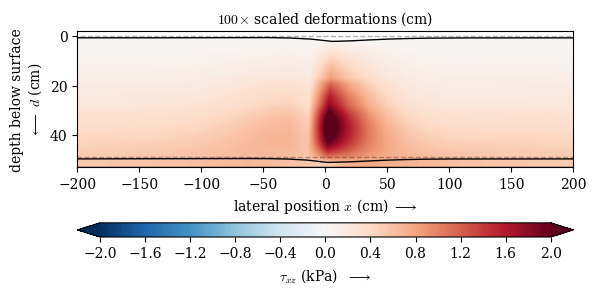

In [74]:
plotter(model).skier_impact_2D(14,field="Txz")

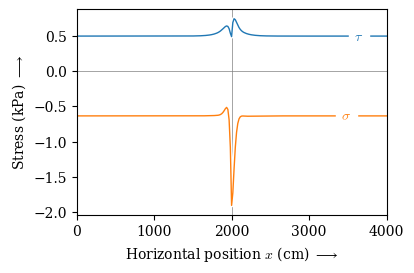

<Axes: >

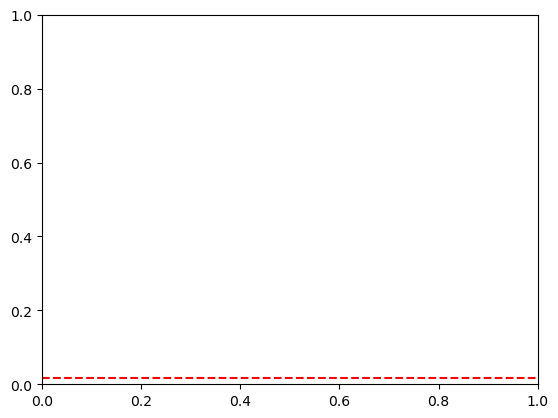

In [75]:
plotter(model).skier_stresses_in_wl(14)
plt.gca()

In [ ]:
model.profile.keys()

In [62]:
plt.close("all")
plotter.density_vs_sth(model, ax2_metric="logarithmic_sensitivity")



AttributeError: 'R2015_point_instability' object has no attribute 'model'

In [174]:
model._get_slab_profile_for_weac(14)

[[122.64785359349136, 151.0],
 [178.249692482522, 2.0],
 [163.1261849045556, 1.0],
 [167.79420244350658, 24.0],
 [151.1585685270931, 3.0],
 [143.80351471955535, 8.0],
 [132.90939567328624, 1.0],
 [156.84457223332967, 41.0],
 [138.49723707103897, 1.0],
 [154.80597181625163, 23.0],
 [145.82946287943912, 2.0],
 [183.94280822087865, 12.0],
 [156.87874174005054, 1.0],
 [205.07249079336702, 218.0]]

## export the postprocessing class to a python file, which can be loaded from other scripts.

In [170]:
import nbformat
# Load the notebook
notebook_filename = "post_processor.ipynb"
with open(notebook_filename, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Extract just one cell's source code
cell_code = nb.cells[1].source

# Save to a Python script
script_filename = "post_processor.py"
with open(script_filename, "w", encoding="utf-8") as f:
    f.write(cell_code)

print(f"post_processor class and functions exported to {script_filename}")

post_processor class and functions exported to post_processor.py
